## Week 5: 
### Comparing distributions among clusters and Finding suspicious inconsistency with the overall distribution.

Roadmap

1. Finding werid correlation between different variable:

- k-means clustering (increase the number of clusters till it tells something (the distributions starting to be bit off):
- compare the distribution among different clusters / compared to the overall distribution). Use visualization and tvd stats

2. If there is some, then don't include them into the prediction. (Later task)

data from:

https://www.kaggle.com/datasets/cityofLA/los-angeles-crime-arrest-data?select=arrest-data-from-2010-to-present.csv

In [1]:
import pandas as pd
arrest = pd.read_csv('arrest-data-from-2010-to-present.csv')
crime = pd.read_csv('crime-data-from-2010-to-present.csv')

## Feature Eng (crime)

In [2]:
crime = crime[['Date Occurred', 'Time Occurred', 'Area ID', 'Area Name', 
               'Crime Code', 'Crime Code Description', 'Victim Sex','Victim Descent', 
               'Premise Code', 'Premise Description',
               'Weapon Used Code', 'Weapon Description', 
               'Status Code','Status Description', 
               'Crime Code 1', 'Crime Code 2', 'Crime Code 3','Crime Code 4', 'Location ']]

In [3]:
#crime code into 4 category (dummies)
crime['Crime Code 1'] = crime['Crime Code 1'].apply(lambda x: 0 if pd.isna(x) else 1)
crime['Crime Code 2'] = crime['Crime Code 2'].apply(lambda x: 0 if pd.isna(x) else 1)
crime['Crime Code 3'] = crime['Crime Code 3'].apply(lambda x: 0 if pd.isna(x) else 1)
crime['Crime Code 4'] = crime['Crime Code 4'].apply(lambda x: 0 if pd.isna(x) else 1)

In [4]:
crime = crime.dropna(axis=0)
crime.shape

(667399, 19)

In [5]:
#date (month, date), and time (hour,  minute)
import datetime
day = crime['Date Occurred'].apply(lambda x: int(str(x)[8:10]))
month = crime['Date Occurred'].apply(lambda x: int(str(x)[5:7]))
hour = crime['Time Occurred'].apply(lambda x: int(str(int(x))[:-2]) if str(int(x))[:-2] != '' else 0)
minute = crime['Time Occurred'].apply(lambda x: int(str(int(x))[-2:]) if str(int(x))[-2:] != '' else 0)

In [6]:
#location (Geographic Areas, latitude, longitude)
import ast
dummies_area_ID = pd.get_dummies(crime['Area ID']) 
latitude = crime['Location '].apply(lambda x: float(ast.literal_eval(x)['latitude']))
longitude = crime['Location '].apply(lambda x: float(ast.literal_eval(x)['longitude']))
#dummies_type_location = pd.get_dummies(crime['Premise Code']) 


In [7]:
#crime code in four category (1 most serious)
code1 = crime['Crime Code 1']
code2 = crime['Crime Code 2']
code3 = crime['Crime Code 3']
code4 = crime['Crime Code 4']

In [8]:
#Victim
victim_sex = pd.get_dummies(crime['Victim Sex'])
victim_race = pd.get_dummies(crime['Victim Descent'])

In [9]:
# status of the case
status = pd.get_dummies(crime['Status Code'])

In [10]:
df_feature_crime = pd.concat({'day':day, 'month':month, 'hour':hour, 'minute': minute, 
                        'area':dummies_area_ID, 'lat':latitude, 'lon':longitude,
                        'code1':code1, 'code2':code2, 'code3':code3, 'code4':code4, 
                        'victim_sex': victim_sex, 'victim_race': victim_race, 'status': status},axis=1)


In [54]:
df_feature_crime.shape

(667399, 62)

## K-means model

In [2]:
from sklearn.cluster import KMeans
import numpy as np

def get_grouping_assignment_crime(df_feature, feature_col, original_feature_col, num_cluster):
    
    df_feature = df_feature.drop(columns = [feature_col]) #not including the prediction variable
    
    X = df_feature.values.tolist()
    y = pd.factorize(crime[original_feature_col])[0] #getting the true label from the original df
    y = y.tolist()
    
    kmeans = KMeans(n_clusters=num_cluster, random_state=0).fit(X)
    
    prediction = []
    for x in X:
        y_pred = kmeans.predict(np.array([x]))
        prediction.append(y_pred)
    
    loss = kmeans.inertia_
    return y, [i[0] for i in prediction], loss


In [3]:
def total_variation_distance(first_distrib, second_distrib):
    '''Computes the total variation distance between two distributions.'''
    return np.sum(np.abs(first_distrib - second_distrib)) / 2

In [5]:
def TVD_on_Victim_Sex(df_feature, cluster_range):
    
    loss_lis = []
    
    for num_cluster in cluster_range:
        
        tvd_lis = []
        
#         print("=======================Start with number of cluster =", num_cluster, '=======================')
        
        group_assignment = get_grouping_assignment_crime(df_feature, 'victim_sex', 'Victim Sex', num_cluster)
        y = group_assignment[0]
        prediction = group_assignment[1]
        loss = group_assignment[2]
        loss_lis.append(loss)
        
        df_results = pd.concat({'sex_label':pd.Series(y).map({0:'F', 1:'M'}), 
                                'grouping':pd.Series(prediction)}, axis=1) 
        
        y_dist_series = df_results.sex_label.value_counts(normalize=True)
        
        #after the clustering process is done, look into only one cluster at a time and calculate the tvd for sex 
        for group in df_results.grouping.unique(): 
            
            pred_dist_series_group = df_results[df_results.grouping == group].sex_label.value_counts(normalize=True)
            df_concat = pd.concat([y_dist_series, pred_dist_series_group], axis=1) #this step is to map the index, should all have sex code as index, and percent as value
            df_concat.columns = ['c1', 'c2']
            
            tvd = total_variation_distance(np.array(df_concat['c1']), np.array(df_concat['c2'])) 
            tvd_lis.append(tvd)
        
        print("average tvd between", str(num_cluster), "cluster and overall distribution:", str(sum(tvd_lis)/len(tvd_lis)))
    
    return loss_lis

            #TODO: simulated TVDs and get the p-value if necessary (if tvd appears to be large)
            #or not? if tvd is large than 0.01 or 0.05, then its clear p-value is gonna be close to 0 (or < 0.01)
            
#             simulated_tvds = np.array([])
#             trials = 5000
#             num_sample = len(prediction)
#             for trial in np.arange(trials):
#                 simulated_empirical = np.random.multinomial(num_sample, np.array(y_dist_series)) / num_sample
#                 current_tvd = total_variation_distance(np.array(df_concat['c1']), simulated_empirical)
#                 simulated_tvds = np.append(simulated_tvds, current_tvd)
                
#             #proportion of times in our simulation that we saw a TVD greater than or equal to our observed TVD.
#             p_value = np.count_nonzero(simulated_tvds >= tvd) / trials
            
        

In [26]:
#testing
loss_lis = TVD_on_Victim_Sex(df_feature_crime, range(2, 10))

=======================Start with number of cluster = 2 =======================
average tvd between cluster and overall distribution: 0.019484336581934547
=======================Start with number of cluster = 3 =======================
average tvd between cluster and overall distribution: 0.030881041969847662
=======================Start with number of cluster = 4 =======================
average tvd between cluster and overall distribution: 0.027169092170423015
=======================Start with number of cluster = 5 =======================
average tvd between cluster and overall distribution: 0.026851284461399
=======================Start with number of cluster = 6 =======================
average tvd between cluster and overall distribution: 0.03086333279085908
=======================Start with number of cluster = 7 =======================
average tvd between cluster and overall distribution: 0.02727258464972359
=======================Start with number of cluster = 8 ===================

In [4]:
def plot_elbow(k_range, loss_lis):
    from matplotlib import pyplot as plt
    plt.plot(k_range, loss_lis)
    plt.title('Optimal num of Cluster')
    plt.xlabel('Num of clusters k')
    plt.ylabel('Sum of squared distances')
    plt.show

the tvd between victim sex (in crime df with 600,000 data) distribution overall and within clusters are **smaller** than the race case (in arrest df with 200,000 data), the loss scores are also **smaller**.

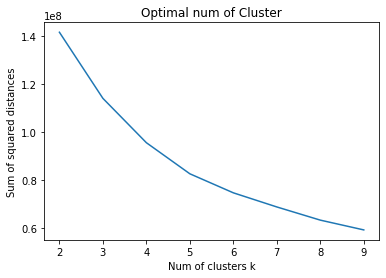

In [40]:
plot_elbow(np.arange(2, 10), loss_lis)

## Feature Eng (arrest)

In [5]:
arrest = arrest.dropna(axis=0)

In [6]:
#date (month, date), and time (hour,  minute)
import datetime
day = arrest['Arrest Date'].apply(lambda x: int(str(x)[8:10]))
month = arrest['Arrest Date'].apply(lambda x: int(str(x)[5:7]))
hour = arrest['Time'].apply(lambda x: int(str(int(x))[:-2]) if str(int(x))[:-2] != '' else 0)
minute = arrest['Time'].apply(lambda x: int(str(int(x))[-2:]) if str(int(x))[:-2] != '' else 0)

In [7]:
#location (Geographic Areas, latitude, longitude)
import ast
area_ID = arrest['Area ID']
latitude = arrest['Location'].apply(lambda x: float(ast.literal_eval(x)['latitude']))
longitude = arrest['Location'].apply(lambda x: float(ast.literal_eval(x)['longitude']))

In [8]:
#charge and arrest type
dummies_arrest = pd.get_dummies(arrest['Arrest Type Code'])
dummies_charge = pd.get_dummies(arrest['Charge Group Code'])

In [9]:
#Age
age = arrest['Age']
#sex
dummies_sex = pd.get_dummies(arrest['Sex Code'])
#race
dummies_race = pd.get_dummies(arrest['Descent Code'])

In [10]:
df_feature = pd.concat({'day':day, 'month':month, 'hour':hour, 'minute': minute, 
                        'area':area_ID, 'lat':latitude, 'lon':longitude, 
                        'arrest':dummies_arrest, 'charge': dummies_charge, 
                        'Age': age, 'Sex Code': dummies_sex, 'Descent Code': dummies_race},axis=1)


In [11]:
df_feature.shape

(208260, 59)

In [12]:
#### K-means model
from sklearn.cluster import KMeans
import numpy as np

def get_grouping_assignment(df_feature, predict_feature, num_cluster):
    
    df_feature = df_feature.drop(columns = [predict_feature])
    
    X = df_feature.values.tolist()
    y = pd.factorize(arrest[predict_feature])[0]
    y = y.tolist()
    
    kmeans = KMeans(n_clusters=num_cluster, random_state=0).fit(X)
    
    prediction = []
    for x in X:
        y_pred = kmeans.predict(np.array([x]))
        prediction.append(y_pred)
        
    loss = kmeans.inertia_
    
    return y, [i[0] for i in prediction], loss


#### training model without race info:
## (Arrest df) Race - use tvd statistic bc its hard to vis when theres too many groups

A Other Asian B - Black C - Chinese D - Cambodian F - Filipino G - Guamanian H - Hispanic/Latin/Mexican I - American Indian/Alaskan Native J - Japanese K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan U - Hawaiian V - Vietnamese W - White X - Unknown Z - Asian Indian

#### Vis on racial distribution overall and within 4 clusters :

A simple testing w/ visualization:

fit K-means models on the all data variables (except race) and set number of clusters to be 4. The distributions of race in each clutser (right pic) doesn't seems to be too off from the overall distributions of race in the arrest dataset. It is not so clear from vis if I do more clusters tho.

Note: only visualizing the four most common race here (each has percentage > 1% in the overall dataset)

<table><tr>
<td> <img src='Screen Shot 2023-02-10 at 3.21.39 AM.png' width='450'> </td>
<td> <img src='Screen Shot 2023-02-10 at 3.21.47 AM.png' width='450'> </td>
</tr></table>


#### Use TVD stats to get the difference between racial distribution in single cluster and overall population and Get the chance that the difference might be due to randomness using 5,000 simulated TVDs 


The function below train a k-means model with different number of clusters (trying from 2 to 9), and print out the total variation distance between the distributions of race overall  and the distribution of race in each cluster

##### results:
The tvd scores go up to around 0.1 when I increase the number of cluster from 2 to 3, and stays about the same from cluster_num = 3 to 9. 

The p-values are not looking so good, from doing 3 clusters to 9 clusters, the tvd is in not in any range of simulated valued (tvd) for any cluster / model.

<strike>If I do simulated TVDs for like 1000 (or 5000) to test if the tvd is reasonable, then it might be obvious (without testing it out) that p-value is gonna be 0 for most clusters, and that shows the race data in each cluster is inconsistent with the overall distribution.</strike>



In [15]:
def TVD_on_Race(df_feature, cluster_range):
    
    loss_lis = []
    
    significant_race = ['B', 'H', 'W', 'O']
    
    race_code_dic = {0:'O', 1:'H', 2:'B', 3:'W', 4:'A', 5:'G', 6:'F', 7:'J', 8:'I', 9:'C', 10:'K', 11:'P', 12:'X', 13:'U', 14:'Z', 15:'S', 16:'L'}

    def total_variation_distance(first_distrib, second_distrib):
        '''Computes the total variation distance between two distributions.'''
        return np.sum(np.abs(first_distrib - second_distrib)) / 2
    
    for num_cluster in cluster_range:
        
        tvd_lis = []
        
        group_assignment = get_grouping_assignment(df_feature, 'Descent Code', num_cluster)
        y = group_assignment[0]
        prediction = group_assignment[1]
        loss = group_assignment[2]
        
        loss_lis.append(loss)
        
        #TODO: does mapping actually work for the predictiuon here?
        df_results = pd.concat({'race_label':pd.Series(y).map(race_code_dic), 
                                'grouping':pd.Series(prediction).map(race_code_dic)}, axis=1) 
        
        #only getting the distribution of 'B', 'H', 'W', 'O'
        y_dist_series = df_results[df_results.race_label.isin(significant_race)].race_label.value_counts(normalize=True)
        
#         print("======================= Model with", num_cluster,  "of cluster =======================")
        
        #after the clustering process is done, look into only one cluster at a time and calculate the tvd for race
        for group in df_results.grouping.unique(): 
            
            pred_dist_series_group = df_results[(df_results.grouping == group) & (df_results.race_label.isin(significant_race))].race_label.value_counts(normalize=True)
            df_concat = pd.concat([y_dist_series, pred_dist_series_group], axis=1) #this step is to map the index, should all have race code as index, and percent as value
            df_concat.columns = ['c1', 'c2']
            
            tvd = total_variation_distance(np.array(df_concat['c1']), np.array(df_concat['c2'])) 
            tvd_lis.append(tvd)
        
        print("average tvd between", str(num_cluster), "cluster and overall distribution:", sum(tvd_lis)/len(tvd_lis))

    return loss_lis

            #TODO: simulated TVDs and get the p-value if necessary (if tvd appears to be large)
            #or not? if tvd is large than 0.01 or 0.05, then its clear p-value is gonna be close to 0 (or < 0.01)
            
#             simulated_tvds = np.array([])
#             trials = 5000
#             num_sample = len(prediction)
#             for trial in np.arange(trials):
#                 simulated_empirical = np.random.multinomial(num_sample, np.array(y_dist_series)) / num_sample
#                 current_tvd = total_variation_distance(np.array(df_concat['c1']), simulated_empirical)
#                 simulated_tvds = np.append(simulated_tvds, current_tvd)
                
#             #proportion of times in our simulation that we saw a TVD greater than or equal to our observed TVD.
#             p_value = np.count_nonzero(simulated_tvds >= tvd) / trials
            
           
            
        

In [17]:
#testing
loss_lis_arrest = TVD_on_Race(df_feature, range(2, 10))

average tvd between 2 cluster and overall distribution: 0.0024517272789975914
average tvd between 3 cluster and overall distribution: 0.07063290482053314
average tvd between 4 cluster and overall distribution: 0.08929064472244505
average tvd between 5 cluster and overall distribution: 0.08868238118332543
average tvd between 6 cluster and overall distribution: 0.08962312330426163
average tvd between 7 cluster and overall distribution: 0.08776917088015476
average tvd between 8 cluster and overall distribution: 0.08652123501262815
average tvd between 9 cluster and overall distribution: 0.08530419351357756


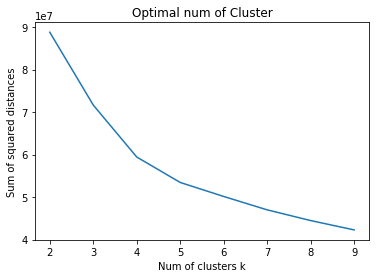

In [20]:
plot_elbow(np.arange(2, 10), loss_lis_arrest)

#### training model without using sex info:
## (Arrest df) Sex - using vis method & tvd

the tvd scores remain to be about < 0.05, which seems good. Will see more by using the simulated TVDs 

In [13]:
def TVD_on_Sex(df_feature, cluster_range):
    
    loss_lis = []
    
    def total_variation_distance(first_distrib, second_distrib):
        '''Computes the total variation distance between two distributions.'''
        return np.sum(np.abs(first_distrib - second_distrib)) / 2
    
    for num_cluster in cluster_range:
        
        tvd_lis = []
        
        group_assignment = get_grouping_assignment(df_feature, 'Sex Code', num_cluster)
        y = group_assignment[0]
        prediction = group_assignment[1]
        loss = group_assignment[2]
        
        loss_lis.append(loss)
        
        df_results = pd.concat({'sex_label':pd.Series(y).map({0:'F', 1:'M'}), 
                                'grouping':pd.Series(prediction)}, axis=1) 
        
        y_dist_series = df_results.sex_label.value_counts(normalize=True)
        
#         print("=======================Start with number of cluster =", num_cluster, '=======================')
        #after the clustering process is done, look into only one cluster at a time and calculate the tvd for sex 
        for group in df_results.grouping.unique(): 
            
            pred_dist_series_group = df_results[df_results.grouping == group].sex_label.value_counts(normalize=True)
            df_concat = pd.concat([y_dist_series, pred_dist_series_group], axis=1) #this step is to map the index, should all have sex code as index, and percent as value
            df_concat.columns = ['c1', 'c2']
            
            tvd = total_variation_distance(np.array(df_concat['c1']), np.array(df_concat['c2'])) 
            tvd_lis.append(tvd)
        
        print("average tvd between", str(num_cluster), "cluster and overall distribution:", sum(tvd_lis)/len(tvd_lis))
        
    return loss_lis

            #TODO: simulated TVDs and get the p-value if necessary (if tvd appears to be large)
            #or not? if tvd is large than 0.01 or 0.05, then its clear p-value is gonna be close to 0 (or < 0.01)
            
#             simulated_tvds = np.array([])
#             trials = 5000
#             num_sample = len(prediction)
#             for trial in np.arange(trials):
#                 simulated_empirical = np.random.multinomial(num_sample, np.array(y_dist_series)) / num_sample
#                 current_tvd = total_variation_distance(np.array(df_concat['c1']), simulated_empirical)
#                 simulated_tvds = np.append(simulated_tvds, current_tvd)
                
#             #proportion of times in our simulation that we saw a TVD greater than or equal to our observed TVD.
#             p_value = np.count_nonzero(simulated_tvds >= tvd) / trials
            
        

In [14]:
loss_lis_arrest_sex = TVD_on_Sex(df_feature, range(2, 10))

average tvd between 2 cluster and overall distribution: 7.269295504486184e-05
average tvd between 3 cluster and overall distribution: 0.03123561490561196
average tvd between 4 cluster and overall distribution: 0.03902762089435825
average tvd between 5 cluster and overall distribution: 0.03802891435792087
average tvd between 6 cluster and overall distribution: 0.03955928285166375
average tvd between 7 cluster and overall distribution: 0.03734016254605949
average tvd between 8 cluster and overall distribution: 0.036089372526867045
average tvd between 9 cluster and overall distribution: 0.036156825489034414


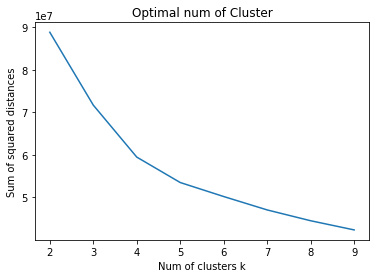

In [15]:
plot_elbow(np.arange(2, 10), loss_lis_arrest_sex)

#### Example Vis for 7 culsters

In [205]:
prediction = get_grouping(df_feature, 'Sex Code', 7)

In [206]:
df_results = pd.concat({'sex_label':pd.Series(y).map({0:'F', 1:'M'}), 'grouping':pd.Series(prediction)}, axis=1)

<AxesSubplot:title={'center':'sex distribution overall'}>

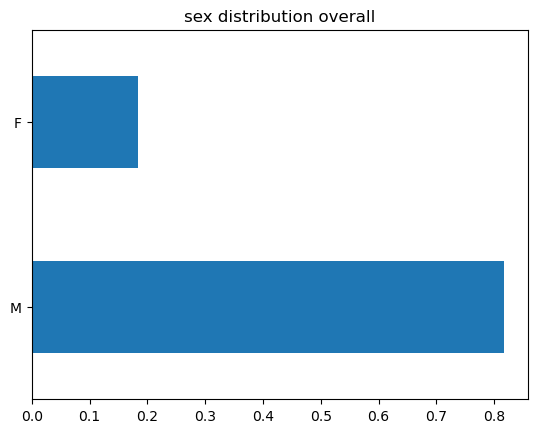

In [208]:
df_results.sex_label.value_counts(normalize=True).plot(kind='barh', title='sex distribution overall')

<AxesSubplot:title={'center':'sex distribution in each group'}, ylabel='grouping,sex_label'>

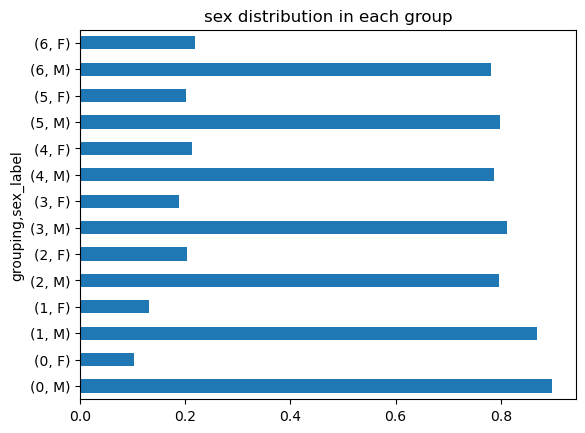

In [209]:
df_results.groupby('grouping')['sex_label'].value_counts(normalize=True).plot(kind='barh', title='sex distribution in each group')


looks like the gender distribution different a lot from group 6 to group 0 (with group 0 clasifying more male cases than the overal distribution which is .8).

Look into what could case this (by looking at other feature variable that differ a lot in group 6 and 0).

In [225]:
df_feature_result = pd.concat({'grouping':df_results.grouping, 
                               'age': age[:1000].reset_index().drop(columns = ['index']).Age, 
                               'race': arrest['Descent Code'][:1000].reset_index().drop(columns = ['index'])['Descent Code']},axis=1)

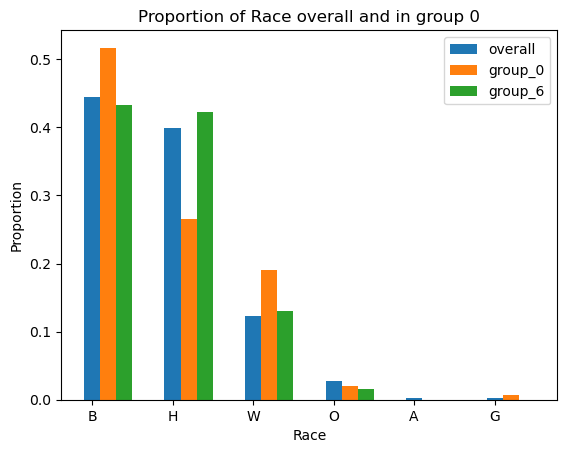

In [261]:
import matplotlib.pyplot as plt 
race_index = ['B', 'H', 'W', 'O', 'A', 'G']
group_0_pro = [0.5170068 , 0.26530612, 0.19047619, 0.02040816, 0, 0.00680272]
group_6_pro = [0.43229167, 0.421875  , 0.13020833, 0.015625, 0, 0]

X_axis = np.arange(len(race_index))

plt.bar(X_axis, df_feature_result['race'].value_counts(normalize=True), 0.2, label = 'overall')
plt.bar(X_axis+0.2, group_0_pro, 0.2, label = 'group_0')
plt.bar(X_axis+0.4, group_6_pro, 0.2, label = 'group_6')

plt.xticks(X_axis, race_index)
plt.xlabel("Race")
plt.ylabel("Proportion")
plt.title("Proportion of Race overall and in group 0")
plt.legend()
plt.show()

race doesn't seem like a important factor here (only from the distribution)

In [260]:
group_6 = df_feature_result[df_feature_result.grouping == 6]
group_6['race'].value_counts(normalize=True).values

array([0.43229167, 0.421875  , 0.13020833, 0.015625  ])